In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import urllib
import string
import re
import nltk
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
tqdm.pandas()

In [2]:
train = pd.read_csv('dataset/train_data.csv')
# Drop the only entry which has neither "body" nor "title" in its webpageDescription
train.drop(index=2994, inplace=True)

test = pd.read_csv('dataset/test_data.csv')

merged_data = pd.concat([train, test], ignore_index=True)

# Convert webpageDescription from string to JSON
merged_data['webpageDescription'] = merged_data['webpageDescription'].apply(lambda x: json.loads(x))

### Fill webpageDescription using either title or body key

There are two approaches to use here for which there are two separate functions,

    - Fill all entries with body key and whereever body is None, fill it with title key => use_title_key()
    - Fill all entries with title key and whereever title is None, fill it with body key => use_body_key()

That's what the two functions listed here do and lambda function will apply it on the webpageDescription column

In [3]:
def use_title_key(x):
    # Some entries don't have title key, in that case add 'title' key with value as None
    # to avoid KeyError in the next if condition
    x.setdefault('title', None)
    
    if x['title'] == None:
        return x['body']
    
    return x['title']

def use_body_key(x):
    if x['body'] == None:
        return x['title']
    
    return x['body']

# COMMENT OR UNCOMMENT THESE LINES DEPENDING ON WHICH DATA YOU WANT IN THE webpageDescription column
# merged_data['webpageDescription'] = merged_data['webpageDescription'].apply(lambda x: use_title_key(x))
merged_data['webpageDescription'] = merged_data['webpageDescription'].apply(lambda x: use_body_key(x))
print(merged_data['webpageDescription'].isna().sum())

0


### Fill in ? values in the columns 

This can be changed as and when we determine new logic to fill in ? values

In [4]:
# Replace all ? values in isNews and isFrontPageNews by new category 'unknown'
merged_data['isNews'] = merged_data['isNews'].apply(lambda x: 'unknown' if x == '?' else x)
        
merged_data['isFrontPageNews'] = merged_data['isFrontPageNews'].apply(lambda x: 'unknown' if x == '?' else x)
    
# Assign all ? values in alchemy_category to "unknown" category
merged_data['alchemy_category'] = merged_data['alchemy_category'].apply(lambda x: 'unknown' if x == '?' else x)
    
# For all ? alchemy_category values we assigned them to "unknown" category
# and we are 100% confident of this assignment
# So we substitute alchemy_category_score = 1.0 (100%) for all ? values which correspond to 'unknown' category
merged_data['alchemy_category_score'] = merged_data['alchemy_category_score'].apply(lambda x: 1.0 if x == '?' else float(x))

### Adding website name feature

In [5]:
# Generate the websiteName feature
def generate_website_name(urls):
    websites = urls.apply(lambda x: urllib.parse.urlparse(x).netloc)

    # Only retain those website_names with atleast 30 entries, assign all other website names to 'other' general category
    websites_counts = websites.value_counts()
    websites_with_atleast_30 = list(websites_counts[websites_counts > 30].index)
    websites = websites.apply(lambda x: x if x in websites_with_atleast_30 else 'other')

    return websites

merged_data['websiteName'] = generate_website_name(merged_data['url'])

### Dropping redundant columns

    framebased because its all 0s
    url because after generating websiteName feature we can drop it
    others because they are highly correlated with other features in the dataset

In [6]:
merged_data.drop(['framebased', 'embedRatio', 'AvglinkWithTwoCommonWord', 'AvglinkWithThreeCommonWord', 'url'], axis=1, inplace=True)

### NLP Processing

Reference: https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words

In [44]:
def preprocess_webpage_description(description, lemmatize=False):
    '''
        Function to convert a raw webpage description to a string of words
        The input is a single string (webpage description), and 
        the output is a single string (a preprocessed webpage description)
    '''

    # 1. Remove HTML
    words = BeautifulSoup(description).get_text() 

    # 2. Remove non-letters        
    words = re.sub("[^a-zA-Z]", " ", words) 

    # 3. Convert to lower case, split into individual words
    words = words.lower().split()                             
    
    # 4. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # 5. Remove stop words
    words = [w for w in words if not w in stops]   
    
    # 6. Stem or Lemmatize the words
    if lemmatize == False:
        porter = PorterStemmer()
        words = [porter.stem(word) for word in words]
    else:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    
    # 7. Join the words back into one string separated by space and return the result.
    return " ".join(words)


def generate_vectorized_data(data_input, vectorizer_name='tfidf', lemmatize=False, max_words_in_vocab=None, vocabulary=None):
    '''
        Takes in dataset input, uses webpageDescription column applies NLP preprocessing on it
        Then gives it to the specified vectorizer and returns vectorized data.
        
        Parameters
        -----------------
        data_input: Dataframe of dataset
        
        vectorizer_name: Can be 'tfidf' or 'count'
        
        lemmatize: True => Data should be lemmatized, False => Data should be stemmed
        
        max_words_in_vocab: Value affects max_features parameter of vectorizer used, if None => all words are used
        
        vocabulary: Custom vocabulary that will be given to the vectorizer as input, if None => vocabulary is determined by the vectorizer

        Returns
        ----------------
        vectorized_data: Dataframe of vectorized data
    '''
    data = data_input.copy(deep=True)
    
    print("Cleaning webpage description...")
    # Preprocess each description in the column according to the function described above
    data['webpageDescription'] = data['webpageDescription'].progress_apply(lambda x: preprocess_webpage_description(x, lemmatize))
    
    # Initialize vectorizer according to input parameters
    if vectorizer_name == "tfidf":
        vectorizer = TfidfVectorizer(max_features=max_words_in_vocab, vocabulary=vocabulary)
    elif vectorizer_name == "count":
        vectorizer = CountVectorizer(max_features=max_words_in_vocab)

    print("Applying vectorizer...")
    
    train_data = data[data['label'].isna() == False]
    test_data = data[data['label'].isna() == True]

    # Apply vectorizer to the data
    # Fit vectorizer on the train data and then transform the test data (avoids data leakages)
    vectorized_train_data = vectorizer.fit_transform(train_data['webpageDescription']).toarray()
    vectorized_test_data = vectorizer.transform(test_data['webpageDescription']).toarray()
        
    vectorized_webpage_description = np.concatenate((vectorized_train_data, vectorized_test_data))
 
    # Converting data to a DataFrame so that it can be processed later more easily
    vectorized_webpage_description = pd.DataFrame(vectorized_webpage_description)
    print("Finished vectorization")
    
    return vectorized_webpage_description, vectorizer

### General Preprocessing

- Takes in features to use for training as input and selects them (id and label are always considered).
- Also takes in vectorized_data as NLP and concatenates it with the sliced data


### NOTE: For all functions that follow from here on, the features_to_use parameter is considered to determine which features to select and process for training
### features_to_use = [] => Use all features

In [43]:
def preprocessing(dataset_input, vectorized_data, features_to_use=[]):
    '''
        Takes in dataset and the vectorized data, concatenates them
        It then takes a susbet of the features specified in 'features_to_use' parameter list
    
        Parameters
        --------------------
        dataset_input: Original input data
        
        vectorized_data: webpage description data that is output of generate_vectorized_data()
        
        features_to_use: Which features to use for training, features_to_use = [] => Use all features
    
        Returns
        --------------------
        processed_data: Concatenated dataframe of original data and vectorized_data by taking subset of features_to_use
    
    '''
    if features_to_use == []:
        features_to_use = dataset_input.columns
    
    # Required features that must always be present
    if 'id' not in features_to_use:
        features_to_use.append('id')
        
    if 'label' not in features_to_use:
        features_to_use.append('label')
    
    # Doing a copy so that the input dataset remains intact
    dataset = dataset_input.copy(deep=True)
    dataset = dataset[features_to_use]
    
    processed_data = pd.concat([dataset, vectorized_data], axis=1)
        
    return processed_data

### Train test split for regular training

This function does the following,
- Takes in the dataset as input which is the output of the preprocessing() function call
- Applies get_dummies on the categorical columns
- Removes webpageDescription & id from the data because they are not required for training
- Applies train_test_split with test_size = 0.3
- Applies StandardScaler by fitting on X_train and transforming both X_train & X_test
- Returns X_train, X_test, y_train, y_test

In [38]:
def preparing_data_for_training(dataset, random_state=42):
    '''
        Takes in the dataset as input which is the output of the preprocessing() function call
        Applies get_dummies on the categorical columns
        Removes webpageDescription & id from the data because they are not required for training
        Applies train_test_split with test_size = 0.3
        Applies StandardScaler by fitting on X_train and transforming both X_train & X_test
        
        Returns
        -----------------------------
        X_train, X_test, y_train, y_test
    '''
    train_data = dataset[dataset['label'].isna() == False]
    
    cur_dataset = train_data.copy(deep=True)
    
    temp_numeric_features = ['alchemy_category_score', 'avgLinkWordLength', 'AvglinkWithOneCommonWord',
                          'AvglinkWithFourCommonWord', 'redundancyMeasure', 'frameTagRatio',
                          'tagRatio', 'imageTagRatio', 'hyperlinkToAllWordsRatio',
                          'alphanumCharCount', 'linksCount', 'wordCount',
                          'parametrizedLinkRatio', 'spellingErrorsRatio'
                         ]
    numeric_features = []
    
    temp_cat_features = ['alchemy_category', 'domainLink', 'isNews', 'isFrontPageNews', 'lengthyDomain', 'websiteName']
    cat_features = []
    
    # Only consider those numeric and categorical features which are actually present in the dataset, i.e. being used for training
    for feature in cur_dataset.columns:
        if feature in temp_cat_features:
            cat_features.append(feature)
        elif feature in temp_numeric_features:
            numeric_features.append(feature)
    
    # Get dummies on categorical columns
    cur_dataset = pd.get_dummies(cur_dataset, columns=cat_features, drop_first=True)

    X = cur_dataset.drop(['label', 'webpageDescription', 'id'], axis=1)
    y = cur_dataset['label']
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
        
    scaler = StandardScaler()
    
    # Standard Scaler requires us to save the changes in a copy instead of the original dataframe so that's why these copies are made
    X_train_copy = X_train.copy(deep=True)
    X_test_copy = X_test.copy(deep=True)
    
    scaler = StandardScaler()
    # Feature Standardization
    for feature in numeric_features:
        scaler.fit(X_train_copy[[feature]])
        X_train_copy[feature] = scaler.transform(X_train_copy[[feature]])
        X_test_copy[feature] = scaler.transform(X_test_copy[[feature]])
    
    return X_train_copy, X_test_copy, y_train, y_test

### Train-test Split for final submission

Very similar to the above function with the few changes being,
- There is no actual train_test_split() call here as we use the full train.csv data
- Apply get_dummies and feature standardization on the entire data (train.csv + test.csv)
- Separates out train.csv and test.csv data from this processed data
- Returns X_train (that has been processed from train.csv), y_train (from train.csv) & X_test (that has been processed from test.csv)

In [39]:
def preparing_data_for_final_submission(dataset):        
    '''
        Apply get_dummies and feature standardization on the entire data (train.csv + test.csv)
        Separates out train.csv and test.csv data from this processed data
        Returns X_train (that has been processed from train.csv), y_train (from train.csv) & X_test (that has been processed from test.csv)
        
        Returns
        ----------------
        X_train, y_train, X_test
    '''
    cur_dataset = dataset.copy(deep=True)
    
    temp_numeric_features = ['alchemy_category_score', 'avgLinkWordLength', 'AvglinkWithOneCommonWord',
                          'AvglinkWithFourCommonWord', 'redundancyMeasure', 'frameTagRatio',
                          'tagRatio', 'imageTagRatio', 'hyperlinkToAllWordsRatio',
                          'alphanumCharCount', 'linksCount', 'wordCount',
                          'parametrizedLinkRatio', 'spellingErrorsRatio'
                         ]

    temp_cat_features = ['alchemy_category', 'domainLink', 'isNews', 'isFrontPageNews', 'lengthyDomain', 'websiteName']

    numeric_features = []
    cat_features = []
    
    # Only consider those numeric and categorical features which are actually present in the dataset
    for feature in cur_dataset.columns:
        if feature in temp_cat_features:
            cat_features.append(feature)
        elif feature in temp_numeric_features:
            numeric_features.append(feature)
    
    # Get dummies on categorical columns
    cur_dataset = pd.get_dummies(cur_dataset, columns=cat_features, drop_first=True)

    scaler = StandardScaler()
    
    # Feature Standardization
    for feature in numeric_features:
        cur_dataset[feature] = scaler.fit_transform(cur_dataset[[feature]])
    
    train_data = cur_dataset[cur_dataset['label'].isna() == False]
    test_data = cur_dataset[cur_dataset['label'].isna() == True]
    
    X_train = train_data.drop(['label', 'webpageDescription', 'id'], axis=1)
    y_train = train_data['label']
    # Do not drop "id" from X_test
    X_test = test_data.drop(['label', 'webpageDescription'], axis=1)
    
    return X_train, y_train, X_test

### Function that runs end-to-end to generate submission file

- If vectorized_data == None, then first calls nlp_preprocessing() using the given parameters (max_words_in_vocab, vectorizer_name) in function call.
- General preprocessing by calling preprocessing()
- Calls preparing_data_for_final_submission()
- Trains on the given model in function call
- Prepares the csv file to submit

In [45]:
def generate_csv_submission(test, y_final_pred, output_file_name='submission.csv'):
    '''
        Parameters
        -----------------------
        test: Test data that contains id column
        
        y_final_pred: predict_proba() output for given model and test data
        
        output_file_name: Name of submission output file
    '''
    submission_df = pd.DataFrame()
    submission_df["id"] = test["id"]
    submission_df["label"] = y_final_pred
    submission_df.to_csv(output_file_name, index=False)

def end_to_end_run(data, model, vectorized_data=None, max_words_in_vocab=None, vocabulary=None, features_to_use=[], lemmatize=True, vectorizer_name='tfidf', output_file_name='submission.csv'):
    '''
        Utility function that does the entire modelling from start to finish
        Vectorizes the data, fit it on the given model and generate submission file
        
        Parameters
        --------------------
        data: Input dataset
        
        model: Model to train data on
        
        vectorized_data: Output of generate_vectorized_data(), if None => this function will call vectorized_data()
        If not None => max_words_in_vocab and vocabulary are ignored
        
        max_words_in_vocab: Used as max_features parameter value for vectorizing
        
        vocabulary: Used as vocabulary parameter value for vectorizing
        
        features_to_use: Which features to use for training
    '''
    if vectorized_data == None:
        vectorized_data, _ = generate_vectorized_data(data, vectorizer_name, lemmatize, max_words_in_vocab, vocabulary)
    
    processed_data = preprocessing(data, vectorized_data, features_to_use)
    
    X_train_final, y_train_final, test = preparing_data_for_final_submission(processed_data)
    model.fit(X_train_final, y_train_final)

    # Drop 'id' before sending for training
    y_final_pred = model.predict_proba(test.drop('id', axis=1))[:, 1]
    
    generate_csv_submission(test, y_final_pred, output_file_name)

### Example use-case of preparing_data_for_training() for model training

In [12]:
vectorized_data, vectorizer = generate_vectorized_data(merged_data, lemmatize=False, max_words_in_vocab=10000, vectorizer_name='tfidf')

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:27<00:00, 272.37it/s]


Applying vectorizer...
Finished vectorization


In [13]:
processed_data = preprocessing(merged_data, vectorized_data, features_to_use=[])

X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

In [14]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_test, y_pred))

0.8628458688713572


### Example use-case of creating final submission using preparing_data_for_final_submission()

In [15]:
X_train_final, y_train_final, test = preparing_data_for_final_submission(processed_data)

In [16]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train_final, y_train_final)

# Drop 'id' before sending for training
y_final_pred = model.predict_proba(test.drop('id', axis=1))[:, 1]

generate_csv_submission(test, y_final_pred, 'test_submission_1.csv')

### Example use-case of end_to_end_run() to create submission file

In [17]:
model = LogisticRegression(max_iter=2000)

end_to_end_run(merged_data, model, max_words_in_vocab=10000, features_to_use=[], vectorizer_name='tfidf', output_file_name='test_submission_2.csv')

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:07<00:00, 935.60it/s]


Applying vectorizer...
Finished vectorization


### Using only the webpageDescription column for submission

In [18]:
model = LogisticRegression(max_iter=2000)

end_to_end_run(data=merged_data, max_words_in_vocab=10000, model=model, features_to_use=['webpageDescription'], vectorizer_name='tfidf', output_file_name='test_submission_3.csv')

Cleaning webpage description...


100%|█████████████████████████████████████| 7394/7394 [00:07<00:00, 1053.84it/s]


Applying vectorizer...
Finished vectorization


### Using KNN Classifier

Spoiler Alert: It sucks ^_^

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:24<00:00, 303.63it/s]


Applying vectorizer...
Finished vectorization
Starting training for K in given range


100%|███████████████████████████████████████████| 95/95 [01:27<00:00,  1.08it/s]

K=5, ROC Score: 0.5771906192312868


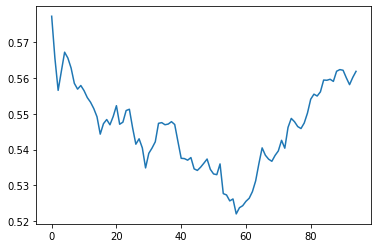

In [19]:
roc_scores = []
vectorized_data, _ = generate_vectorized_data(merged_data, lemmatize=False, max_words_in_vocab=10000, vectorizer_name='tfidf')
processed_data = preprocessing(merged_data, vectorized_data, features_to_use=['webpageDescription'])
X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

max_K = 100
print("Starting training for K in range ({}. {})".format(5, max_K))
for k in tqdm(range(5, max_K)):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_scores.append(roc_auc_score(y_test, y_pred))

print("Best Results: K={}, ROC Score: {}".format(np.argmax(roc_scores) + 5, roc_scores[np.argmax(roc_scores)]))

plt.plot(roc_scores)

### Applying Chi-Squared test to pick most relevant words out of given data

The Chi-Squared test checks whether each feature given in the dataset is independent of the target variable or not by considering each feature individually. But the feature must take non-negative values which in our case is perfectly fine as we're considering TF-IDF values which are always positive.

It computes the p-value for each feature which tells you how effective that feature is (individually) to predict the target variable.

It takes the Null Hypothesis which assumes that the feature and target variable are independent.

Lower the p-value, the better the feature is.

On the basis of this, the p-score is defined as, 1 - p_value

A p_score of 0.95 is typically considered to be a good indicator of a feature being useful for prediction process.

p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random). Therefore, we reject the null hypothesis, and accept the alternative hypothesis.

In our task, we have around 80,000 words in the entire dataset and we prune it further to around 10-40 thousand using the max_features parameter of the vectorizer object to pick the most frequent words.

But we can prune this even further with the help of this test and only choosing those words which have p-score >= 0.95

Starting with vectorized_data of 10,000 words which will be analyzed by the test

In [20]:
vectorized_data, vectorizer = generate_vectorized_data(merged_data, lemmatize=False, max_words_in_vocab=10000, vectorizer_name='tfidf')

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:24<00:00, 301.40it/s]


Applying vectorizer...
Finished vectorization


In [21]:
processed_data = preprocessing(merged_data, vectorized_data, features_to_use=['webpageDescription'])

X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

vocab_words = vectorizer.get_feature_names()

# Min value of p_score required is p_limit
p_limit = 0.95

### Running the Chi-Squared test and storing the results in a DataFrame and sorting DF by p_score value

In [22]:
chi2_stats, p = chi2(X_train, y_train)

p_score_per_word = pd.DataFrame({"feature":vocab_words, "score":1-p})

# Sorting in descending order of p-score value
p_score_per_word.sort_values('score', ascending=False)

,feature,score
7209,recip,1.0
2154,cup,1.0
633,bake,1.0
1499,chees,1.0
1203,butter,1.0
...,...,...
9923,yakuza,NaN
9947,yoder,NaN
9976,zetaclear,NaN
9977,zhao,NaN


In [23]:
p_score_per_word_filtered = p_score_per_word[p_score_per_word['score'] > p_limit]

p_score_per_word_filtered

,feature,score
87,add,1.000000
246,almond,0.956293
314,android,0.954929
386,app,0.970936
482,asid,0.985907
...,...,...
9893,wrap,0.967129
9936,yeast,0.976146
9950,yogurt,0.973270
9974,zest,0.978068


    Filtering by p_score value >= 0.95 resulted in only 305 words remaining, we'll try to model using
    only these features

In [24]:
filtered_words = p_score_per_word_filtered["feature"].unique().tolist()

### Vectorizing the data again

But this time, we only consider the filtered words as the input vocabulary to the vectorizer.

In [25]:
new_vectorized_data, new_vectorizer = generate_vectorized_data(merged_data, vocabulary=filtered_words)

Cleaning webpage description...


100%|██████████████████████████████████████| 7394/7394 [00:24<00:00, 298.60it/s]


Applying vectorizer...
Finished vectorization


In [39]:
processed_data = preprocessing(merged_data, new_vectorized_data, features_to_use=['webpageDescription'])

X_train, X_test, y_train, y_test = preparing_data_for_training(processed_data, random_state=69)

print(X_train.shape)

(4140, 305)


### Heatmap of the new vectorized data

With the original X data the matrix was mostly sparse whereas this heatmap shows just how dense this data is in comparison

<AxesSubplot:>

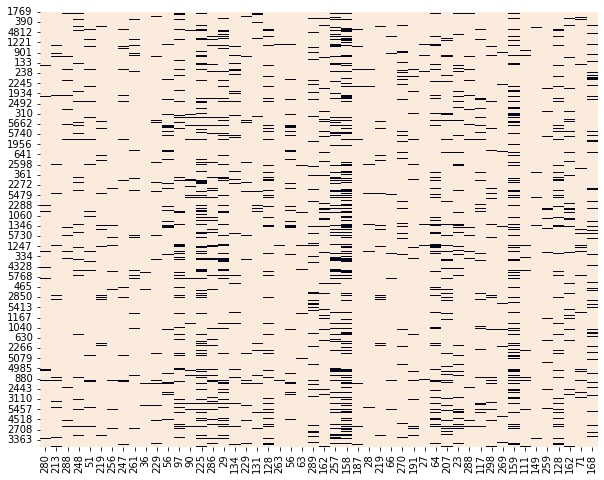

In [45]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.iloc[:,np.random.randint(0,X_train.shape[1],50)]==0, vmin=0, vmax=1, cbar=None)

### Training Logistic Regression model

In [47]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_test, y_pred))

0.855166100851389


    We got an ROC score of 0.85 even though we worked with just 305 words/features in comparison to the 10,000 
    word vocabulary of the previous model which gave a score 0.86

    Although the score decreased, this approach shows great merit in the fact that even after removing so many words, the score remains very close to the original model showing just how redundant the original data is and how much memory and time can be saved by using this reduced feature matrix in exchange for slightly reduced accuracy

    We submitted the following CSV file to Kaggle and we actually got a score of 0.86 on the public leaderboard so that's a great sign as well


In [58]:
X_train_final, y_train_final, test = preparing_data_for_final_submission(processed_data)

model = LogisticRegression(max_iter=2000)
model.fit(X_train_final, y_train_final)

# Drop 'id' before sending for training
y_final_pred = model.predict_proba(test.drop('id', axis=1))[:, 1]

generate_csv_submission(test, y_final_pred, 'chi-squared-305-words-submission.csv')

### Trying Multinomial Naive Bayes model

In [59]:
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_test, y_pred))

0.8595976151965203
